# Part II: Road Lane Detection Using Hough Transform

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
img = cv2.imread('Part II Tests/testHough.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

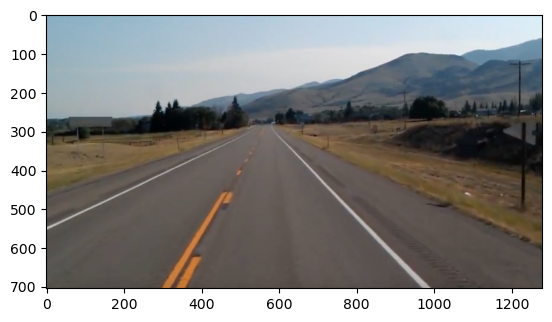

In [3]:
plt.imshow(img)

### Smoothing the image

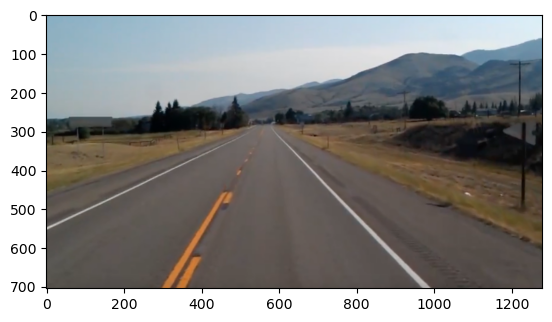

In [93]:
img_smoothed = cv2.medianBlur(img, 3)
plt.imshow(img_smoothed)

### Edge Detection

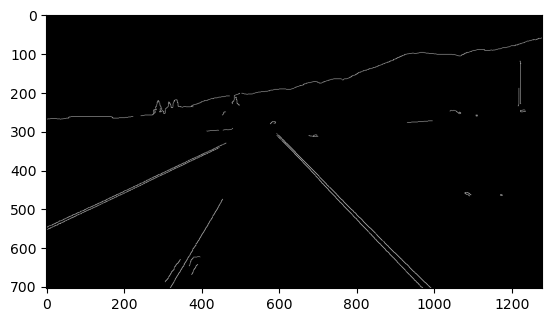

In [5]:
edges = cv2.Canny(img_smoothed, 150, 250)
plt.imshow(edges, cmap='gray')

### Region Of Interest

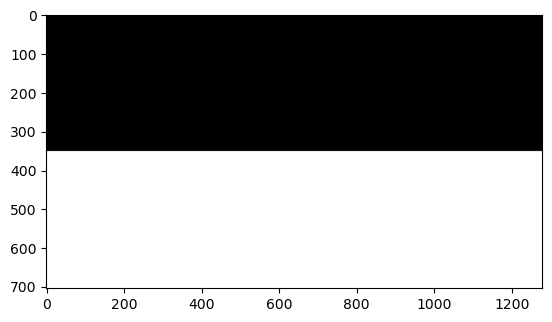

In [6]:
width, height, _ = img_smoothed.shape
mask = np.zeros(img_smoothed.shape[:2], dtype="uint8")
#cv2.rectangle(mask, (0, 90), (290, 450), 255, -1)
cv2.rectangle(mask, (0, int(0.5*width)), (height, width), 255, -1)
plt.imshow(mask, cmap='gray')

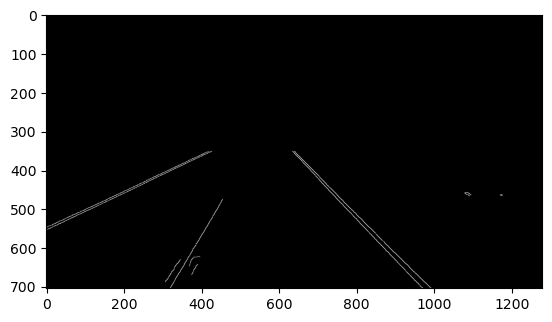

In [7]:
edges_masked = cv2.bitwise_and(edges, edges, mask=mask)
plt.imshow(edges_masked, cmap='gray')

### Accumulation into (ρ, θ)-space using Hough transform

Custom implementation:

In [8]:
def hough_transform_line(img, edge_image, num_rhos=180, num_thetas=180, t_count=500):
    img_copy = img.copy()
    edge_height, edge_width = edge_image.shape[:2]
    edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
    
    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    dtheta = 180 / num_thetas
    drho = (2 * d) / num_rhos
    
    thetas = np.arange(0, 180, step=dtheta)
    rhos = np.arange(-d, d, step=drho)
  
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
  
    accumulator = np.zeros((len(rhos), len(thetas)))
  
    for y in range(edge_height):
        for x in range(edge_width):
            if edge_image[y][x] != 0:
                edge_point = [y - edge_height_half, x - edge_width_half]
                for theta_idx in range(len(thetas)):
                    rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
                    rho_idx = np.argmin(np.abs(rhos - rho))
                    accumulator[rho_idx][theta_idx] += 1

    for x in range(accumulator.shape[0]):
        for y in range(accumulator.shape[1]):
            if accumulator[x][y] > t_count:
                rho = rhos[x]
                theta = thetas[y]
                a = np.cos(np.deg2rad(theta))
                b = np.sin(np.deg2rad(theta))
                x0 = (a * rho) + edge_width_half
                y0 = (b * rho) + edge_height_half
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                
                cv2.line(img_copy, (x1,y1), (x2,y2), (0,255,0), 2)

    return img_copy, accumulator

In [9]:
img_copy, accumulator = hough_transform_line(img_smoothed, edges_masked)

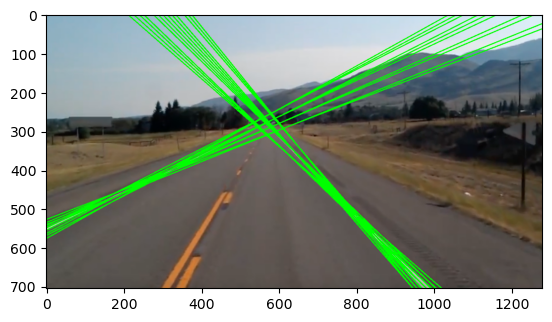

In [10]:
plt.imshow(img_copy)

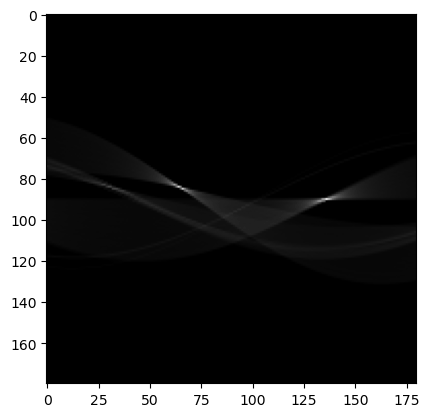

In [11]:
plt.imshow(accumulator, cmap='gray')

OpenCV implementation:

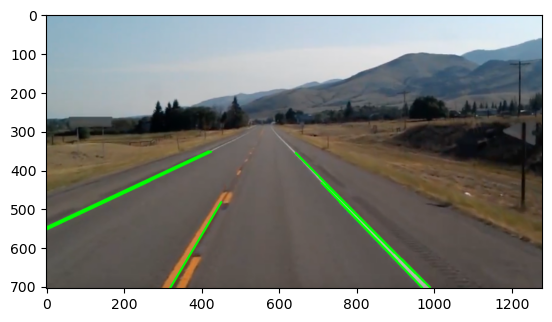

In [12]:
lines = cv2.HoughLinesP(edges_masked, rho=1, theta=np.pi/180, threshold=125, minLineLength=5, maxLineGap=25)

if lines is not None:
    for i in range(len(lines)):
        l = lines[i][0]
        cv2.line(img_smoothed, (l[0], l[1]), (l[2], l[3]), (0,255,0), 3, cv2.LINE_AA)

plt.imshow(img_smoothed)

### Refining Coordinates and HT Post-Processing

In [51]:
import itertools
from scipy.spatial.distance import pdist

In [14]:
def manhattan_distance(point1, point2):
    distance = 0
    for x1, x2 in zip(point1, point2):
        difference = x2 - x1
        absolute_difference = abs(difference)
        distance += absolute_difference
    return distance

In [65]:
def non_max_suppression(accumulator, n_points, min_locality_distance):
    return accumulator

N = 10

# Convert it into a 1D array
a_1d = accumulator.flatten()

# Find the indices in the 1D array
idx_1d = a_1d.argsort()[-N:]

# convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, accumulator.shape)

# Check that we got the largest values.
points = []
for x, y, in zip(x_idx, y_idx):
    #print(x, y, accumulator[x][y])
    points.insert(0,[x, y])

min_locality_distance = 80
points = np.array(points)
final_points = []

for i in range(len(points)):
    for j in range(len(points)):
        if i == j:
            continue
        distance = manhattan_distance(points[i], points[j])
        #print(distance)
        if distance > min_locality_distance:
            final_points.append(points[i])
print(final_points)

[array([ 90, 136], dtype=int64), array([ 90, 137], dtype=int64), array([ 90, 138], dtype=int64), array([83, 62], dtype=int64), array([83, 62], dtype=int64), array([83, 62], dtype=int64)]


In [106]:
Npoints = 3
# making up some data:
# finding row indices of all combinations:
c = [list(x) for x in itertools.combinations(range(len(points)), Npoints)]

distances = []
for i in c:    
    distances.append(np.mean(pdist(points[i,:])))
ind = distances.index(max(distances))
rows = c[ind]

In [107]:
rows

[2, 5, 6]

In [108]:
points[rows]

array([[ 85,  66],
       [ 90, 138],
       [ 83,  62]], dtype=int64)

In [109]:
for x in range(accumulator.shape[0]):
    for y in range(accumulator.shape[1]):
        if [x,y] not in points[rows]:
            accumulator[x][y] = 0

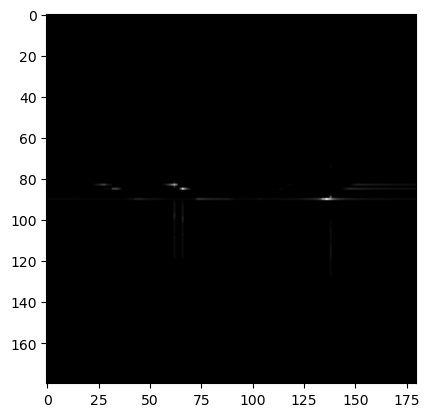

In [110]:
plt.imshow(accumulator, cmap='gray')

In [103]:
def hough_apply_line(img, edge_image, accumulator, num_rhos=180, num_thetas=180, t_count=500):
    
    edge_height, edge_width = edge_image.shape[:2]
    edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
    
    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    dtheta = 180 / num_thetas
    drho = (2 * d) / num_rhos
    
    thetas = np.arange(0, 180, step=dtheta)
    rhos = np.arange(-d, d, step=drho)
    
    for x in range(accumulator.shape[0]):
        for y in range(accumulator.shape[1]):
            if accumulator[x][y] > t_count:
                rho = rhos[x]
                theta = thetas[y]
                a = np.cos(np.deg2rad(theta))
                b = np.sin(np.deg2rad(theta))
                x0 = (a * rho) + edge_width_half
                y0 = (b * rho) + edge_height_half
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                cv2.line(img, (x1,y1), (x2,y2), (0,255,0), 2)
    return img

In [111]:
img3 = hough_apply_line(img_copy2, edges_masked, accumulator)

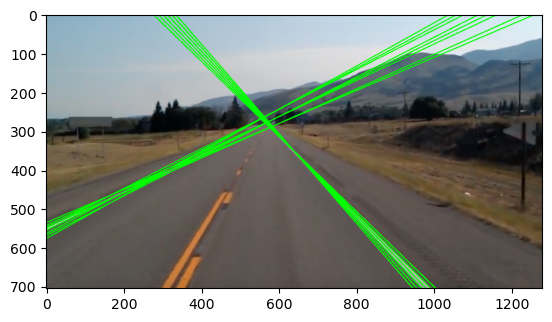

In [112]:
plt.imshow(img3)